In [1]:
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.0 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import evaluate
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix , ConfusionMatrixDisplay
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
)
import torch
from datasets import DatasetDict
from datasets import load_dataset
from transformers import TrainerCallback
import matplotlib.pyplot as plt
import os
from datasets import load_from_disk

In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')


  gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!
Fri Dec  6 04:04:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              41W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |        

In [5]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)

tokenizer = AutoTokenizer.from_pretrained('roberta-base')
model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

# Directory to save/load the tokenized dataset
tokenized_dataset_path = "./tokenized_imdb_base"


if os.path.exists(tokenized_dataset_path):
    # Load tokenized dataset if it exists
    tokenized_datasets = load_from_disk(tokenized_dataset_path)
    print("Tokenized dataset loaded from disk.")
else:
    dataset = load_dataset("stanfordnlp/imdb")
    tokenized_datasets = dataset.map(tokenize_function, batched=True)

    # Rename 'label' to match Transformers expectations
    tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

    # Remove unnecessary columns
    tokenized_datasets = tokenized_datasets.remove_columns(["text"])

    # Convert datasets to PyTorch format
    tokenized_datasets.set_format("torch")

    tokenized_datasets.save_to_disk(tokenized_dataset_path)
    print("Tokenized dataset saved to disk.")

# Split the dataset
train_dataset = tokenized_datasets["train"]
test_dataset = tokenized_datasets["test"]


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/25000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/25000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/50000 [00:00<?, ? examples/s]

Tokenized dataset saved to disk.


In [6]:
!cp -r ./tokenized_imdb_base /content/drive/MyDrive/

In [7]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, zero_division=0.0, average="binary", pos_label=1)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn
    }


In [8]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./results",               # Output directory
    evaluation_strategy="epoch",         # Evaluate every epoch
    learning_rate=2e-5,                  # Learning rate
    per_device_train_batch_size=32,      # Batch size for training
    per_device_eval_batch_size=32,       # Batch size for evaluation
    num_train_epochs=10,                  # Number of epochs
    weight_decay=0.005,                   # Weight decay
    logging_dir="./logs",                # Directory for logs
    logging_steps=100,                   # Log every 100 steps
    logging_first_step=True,
    save_strategy="epoch",               # Save checkpoints every epoch
    load_best_model_at_end=True,         # Load best model after training
    metric_for_best_model="accuracy",    # Metric to monitor
    gradient_accumulation_steps=4  ,    # Gradient accumulation steps.  4 mins with cosine
    fp16=True  # Enables mixed precision
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [9]:
training_logs = []

class CustomCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        logs = logs or {}
        if any(key.startswith("eval_") for key in logs):
            training_logs.append({
                "epoch": state.epoch,
                "loss": logs.get("eval_loss", None),  # Get loss if available, otherwise None
                "accuracy": logs.get("eval_accuracy", None)
            })

trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    data_collator=data_collator,
    train_dataset=train_dataset,   # Pass the training dataset here
    eval_dataset=test_dataset, # Pass the evaluation/validation dataset here
    compute_metrics=compute_metrics
)
trainer.add_callback(CustomCallback)

<ipython-input-9-eaad43ca91cb>:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [10]:
trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Tp,Tn,Fp,Fn
0,0.294800,0.140751,0.947760,0.950644,0.944560,0.947592,11807,11887,613,693
2,0.091800,0.142848,0.952080,0.935295,0.971360,0.952986,12142,11660,840,358
4,0.039500,0.168049,0.953120,0.946336,0.960720,0.953474,12009,11819,681,491
6,0.026100,0.236252,0.953240,0.942099,0.965840,0.953822,12073,11758,742,427
8,0.017900,0.282024,0.953840,0.946271,0.962320,0.954228,12029,11817,683,471


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Tp,Tn,Fp,Fn
0,0.294800,0.140751,0.947760,0.950644,0.944560,0.947592,11807,11887,613,693
2,0.091800,0.142848,0.952080,0.935295,0.971360,0.952986,12142,11660,840,358
4,0.039500,0.168049,0.953120,0.946336,0.960720,0.953474,12009,11819,681,491
6,0.026100,0.236252,0.953240,0.942099,0.965840,0.953822,12073,11758,742,427
8,0.015200,0.304063,0.954520,0.952457,0.956800,0.954623,11960,11903,597,540
9,0.010700,0.304485,0.955000,0.950424,0.960080,0.955227,12001,11874,626,499


TrainOutput(global_step=1950, training_loss=0.06664175553199572, metrics={'train_runtime': 1295.5275, 'train_samples_per_second': 192.972, 'train_steps_per_second': 1.505, 'total_flos': 6.561568742989824e+16, 'train_loss': 0.06664175553199572, 'epoch': 9.974424552429667})

In [11]:

model.save_pretrained("/content/drive/My Drive/fine_tuned_model_base")

In [12]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/My Drive/fine_tuned_model_base")


In [14]:
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)
conf_matrix = confusion_matrix(test_dataset["labels"], trainer.predict(test_dataset).predictions.argmax(-1))
metrics = trainer.compute_metrics(trainer.predict(test_dataset))


epochs = [log["epoch"] for log in training_logs]
losses = [log["loss"] for log in training_logs]
accuracies = [log["accuracy"] for log in training_logs]
# Smooth accuracies for plotting (fill NaN values)
accuracies = np.array([float(value) if value is not None else np.nan for value in accuracies], dtype=float)
accuracies = np.nan_to_num(accuracies, nan=np.mean(accuracies))  # Replace NaN with the mean of available values


# Step 7: Plot Loss vs Accuracy




Evaluation Results: {'eval_loss': 0.30448490381240845, 'eval_accuracy': 0.955, 'eval_precision': 0.9504236952561971, 'eval_recall': 0.96008, 'eval_f1': 0.9552274445815259, 'eval_tp': 12001, 'eval_tn': 11874, 'eval_fp': 626, 'eval_fn': 499, 'eval_runtime': 32.5837, 'eval_samples_per_second': 767.255, 'eval_steps_per_second': 24.0, 'epoch': 9.974424552429667}


In [15]:
print(training_logs)

[{'epoch': 0.9974424552429667, 'loss': 0.14075110852718353, 'accuracy': 0.94776}, {'epoch': 2.0, 'loss': 0.13109749555587769, 'accuracy': 0.95224}, {'epoch': 2.997442455242967, 'loss': 0.14284762740135193, 'accuracy': 0.95208}, {'epoch': 4.0, 'loss': 0.16030040383338928, 'accuracy': 0.95312}, {'epoch': 4.997442455242966, 'loss': 0.16804856061935425, 'accuracy': 0.95312}, {'epoch': 6.0, 'loss': 0.2449961006641388, 'accuracy': 0.95324}, {'epoch': 6.997442455242966, 'loss': 0.23625192046165466, 'accuracy': 0.95324}, {'epoch': 8.0, 'loss': 0.2820238769054413, 'accuracy': 0.95384}, {'epoch': 8.997442455242966, 'loss': 0.3040626049041748, 'accuracy': 0.95452}, {'epoch': 9.974424552429667, 'loss': 0.30448490381240845, 'accuracy': 0.955}, {'epoch': 9.974424552429667, 'loss': 0.30448490381240845, 'accuracy': 0.955}]


In [16]:
def plot_loss_vs_accuracy(epochs, losses, accuracies):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    print(len(epochs), len(losses), len(accuracies))
    # Plot loss
    ax1.plot(epochs, losses, 'b-', label="Loss", linewidth=2)
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss", color="b")
    ax1.tick_params(axis="y", labelcolor="b")
    ax1.legend(loc="upper left")

    # Normalize accuracy if needed
    if max(accuracies) > 1:  # Assuming accuracy is in percentage
        normalized_accuracies = [acc / 100 for acc in accuracies]
    else:
        normalized_accuracies = accuracies

    # Plot accuracy on a secondary axis
    ax2 = ax1.twinx()
    ax2.plot(epochs, normalized_accuracies, 'r--', label="Accuracy", linewidth=2)
    ax2.set_ylabel("Accuracy", color="r")
    ax2.tick_params(axis="y", labelcolor="r")
    ax2.legend(loc="upper right")

    # Add title and layout adjustments
    plt.title("Loss vs Accuracy Over Epochs")
    fig.tight_layout()
    plt.show()


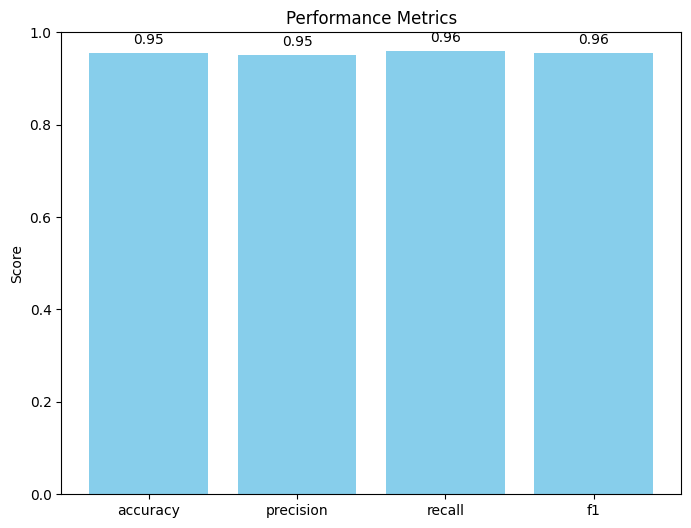

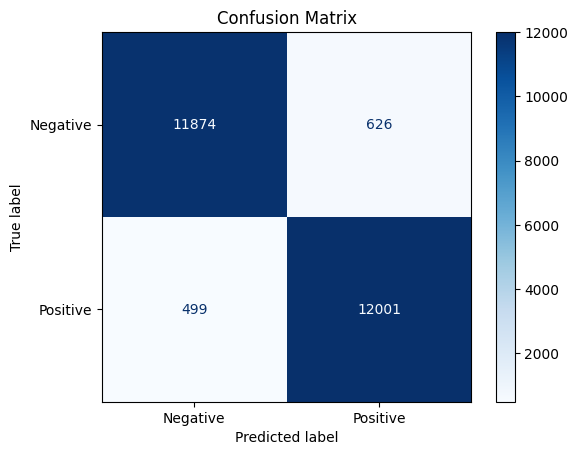

11 11 11


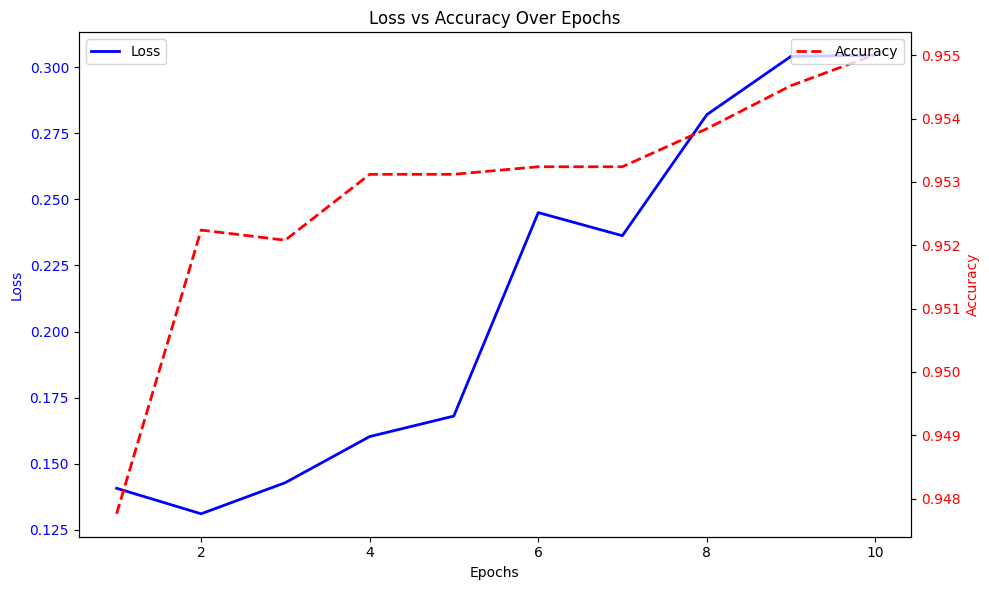

In [17]:
def plot_metrics(metrics):
    # Metrics to display
    metric_keys = ["accuracy", "precision", "recall", "f1"]
    metric_values = [metrics[key] for key in metric_keys]

    # Plot metrics bar chart
    plt.figure(figsize=(8, 6))
    plt.bar(metric_keys, metric_values, color='skyblue')
    plt.title("Performance Metrics")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    for i, value in enumerate(metric_values):
        plt.text(i, value + 0.02, f"{value:.2f}", ha="center", fontsize=10)
    plt.show()

# Step 8: Plot Confusion Matrix
def plot_confusion_matrix(conf_matrix):
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Negative", "Positive"])
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

# Call the plotting functions
plot_metrics(metrics)
plot_confusion_matrix(conf_matrix)
plot_loss_vs_accuracy(epochs, losses, accuracies)
